# 🔬 Simulación Cuántica H₂ - Paper arXiv:2405.05696v1

**CORRECCIÓN: Frame de Interacción (Imagen de Interacción)**

**Nota Importante**: En la versión anterior, la inclusión de las energías libres ($\hbar \Omega \approx 10^9$) causaba oscilaciones extremadamente rápidas que enmascaraban la dinámica de entrelazamiento relevante (determinada por $g \approx 10^7$).

En este notebook, simulamos en la **Imagen de Interacción**, eliminando los términos diagonales de alta frecuencia ($H_0$). Esto es válido para calcular la entropía de von Neumann, ya que la entropía es invariante bajo rotaciones locales unitarias ($S(\rho) = S(U \rho U^\dagger)$).

In [14]:
import sys
if 'google.colab' in sys.modules:
    !pip install -q numpy scipy matplotlib tqdm
    print('✅ Dependencias instaladas!')

✅ Dependencias instaladas!


In [15]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

In [16]:
# ==========================================
# 🔧 PARÁMETROS
# ==========================================

# Dimensiones de truncamiento (Espacio de Fock)
# Aumentar si es necesario, pero 3-4 suele ser suficiente para ver la dinámica cualitative
DIM_PHOTON = 5
DIM_PHONON = 5

# Parámetros Físicos
HBAR = 1.0
# NOTA: OMEGA_PHOTON y OMEGA_PHONON no se usan explícitamente en el Hamiltoniano de interacción
# porque estamos en resonancia y en el frame rotante.
G_BASE = 1e7          # g

# Dimensiones del sistema: [p1, p2, m, l1, l2, L, k]
DIMS = [DIM_PHOTON, DIM_PHOTON, DIM_PHONON, 2, 2, 2, 2]
TOTAL_DIM = int(np.prod(DIMS))

print(f'📐 Hilbert Space Size: {TOTAL_DIM}')

📐 Hilbert Space Size: 2000


In [17]:
# ==========================================
# 📦 OPERADORES
# ==========================================

def a_op(d):
    """Annihilation operator"""
    a = np.zeros((d, d), dtype=complex)
    for n in range(1, d):
        a[n-1, n] = np.sqrt(n)
    return a

def adag_op(d):
    """Creation operator"""
    return a_op(d).conj().T

def sigma_m():
    """|0><1|"""
    return np.array([[0, 1], [0, 0]], dtype=complex)

def sigma_p():
    """|1><0|"""
    return np.array([[0, 0], [1, 0]], dtype=complex)

def sigma_n():
    """|1><1|"""
    return np.array([[0, 0], [0, 1]], dtype=complex)

def eye(d):
    return np.eye(d, dtype=complex)

def embed_op(op_dict, dims=DIMS):
    """Embed operators into full Hilbert space tensor product."""
    # Start from last subsystem (rightmost in Kronecker product usually, depending on convention)
    # NumPy kron is A (x) B.
    # Let's map index 0 to dims[0].
    
    ops = []
    for i, dim in enumerate(dims):
        if i in op_dict:
            ops.append(op_dict[i])
        else:
            ops.append(eye(dim))
            
    # Compute Kronecker product
    res = ops[0]
    for op in ops[1:]:
        res = np.kron(res, op)
    return res

In [18]:
# ==========================================
# ⚛️ HAMILTONIANO (INTERACTION PICTURE)
# ==========================================

def build_hamiltonian(g_omega, g_phonon, zeta, dims=DIMS):
    """
    Construye H_int (solo términos de interacción).
    Se omiten los términos HBAR * OMEGA * n.
    """
    d_p = dims[0]
    d_m = dims[2]
    
    # Operadores básicos
    a_p, adag_p = a_op(d_p), adag_op(d_p)
    a_m, adag_m = a_op(d_m), adag_op(d_m)
    sm, sp, sn = sigma_m(), sigma_p(), sigma_n()
    I2 = eye(2)
    
    H = np.zeros((TOTAL_DIM, TOTAL_DIM), dtype=complex)
    
    # Proyectores
    # Bond formed (L): |0><0| = I - |1><1|
    P_bond_formed = I2 - sn
    # Nuclei together (k): |0><0|
    P_nuclei_together = I2 - sn
    
    # 1. Interacción Radiación-Materia (Jaynes-Cummings) x 2
    # H_JC = g_omega * (a^dag sigma_- + a sigma_+) * P_bond_formed
    # Nota: Paper Ec 4 dice (a^dag sigma + a sigma^dag). 
    # sigma en el paper (Ec 6) baja de |1> a |0>. Coincide con sigma_m (sm).
    
    # Fotón UP (idx 0) <-> Electrón UP (idx 3)
    # Term: a_up^dag * sigma_up + a_up * sigma_up^dag
    jc_up = embed_op({0: adag_p, 3: sm, 5: P_bond_formed}, dims) + \
            embed_op({0: a_p, 3: sp, 5: P_bond_formed}, dims)
    H += g_omega * jc_up
    
    # Fotón DOWN (idx 1) <-> Electrón DOWN (idx 4)
    jc_down = embed_op({1: adag_p, 4: sm, 5: P_bond_formed}, dims) + \
              embed_op({1: a_p, 4: sp, 5: P_bond_formed}, dims)
    H += g_omega * jc_down
    
    # 2. Interacción Fonón-Enlace
    # H_ph = g_phonon * (a_m^dag sigma_bond + a_m sigma_bond^dag)
    # P_together constraint? Paper Eq 4 doesn't explicitly have it on the phonon term,
    # but physically hybridization requires nuclei together. Code implied it.
    # Vamos a asumir la restricción P_nuclei_together (k=0) como en implementaciones previas.
    ph_term = embed_op({2: adag_m, 5: sm, 6: P_nuclei_together}, dims) + \
              embed_op({2: a_m, 5: sp, 6: P_nuclei_together}, dims)
    H += g_phonon * ph_term
    
    # 3. Tunelamiento
    # H_tun = zeta * (sigma_k + sigma_k^dag)
    # Esto es sigma_x en el subsistema k (idx 6)
    SX = sm + sp
    H += zeta * embed_op({6: SX}, dims)
    
    return H

# Test
H_test = build_hamiltonian(G_BASE, G_BASE, G_BASE)
print(f'✅ Hamiltoniano construido. Hermítico: {np.allclose(H_test, H_test.conj().T)}')

✅ Hamiltoniano construido. Hermítico: True


In [19]:
# ==========================================
# 🏁 ESTADO INICIAL
# ==========================================

def get_psi0(dims=DIMS):
    # Indices: p1, p2, m, l1, l2, L, k
    # |Psi> = 0.5 * ( |00> + |10> - |01> - |11> )_electrons X |vacuum>_bosons X |1>_L |1>_k
    
    psi = np.zeros(TOTAL_DIM, dtype=complex)
    
    def set_val(p1, p2, m, l1, l2, L, k, val):
        # Calcular índice lineal
        idx = 0
        stride = 1
        # Orden inverso para coincidir con la lógica de kron anterior (último indice varía más rápido)
        # dims = [p1, p2, m, l1, l2, L, k]
        # En np.kron(A, B), B varía más rápido. 
        # Así que k (último en lista) es el que varía más rápido.
        coords = [p1, p2, m, l1, l2, L, k]
        
        # Multi-index to flat index
        current_stride = 1
        # Iterar desde el final (k) hacia el principio
        for i in range(len(dims)-1, -1, -1):
            idx += coords[i] * current_stride
            current_stride *= dims[i]
            
        psi[idx] += val

    # |Φ0↑Φ0↓⟩ -> l1=0, l2=0. L=1, k=1
    set_val(0,0,0, 0,0, 1,1, 0.5)
    # |Φ1↑Φ0↓⟩ -> l1=1, l2=0. L=1, k=1
    set_val(0,0,0, 1,0, 1,1, 0.5)
    # -|Φ0↑Φ1↓⟩ -> l1=0, l2=1. L=1, k=1
    set_val(0,0,0, 0,1, 1,1, -0.5)
    # -|Φ1↑Φ1↓⟩ -> l1=1, l2=1. L=1, k=1
    set_val(0,0,0, 1,1, 1,1, -0.5)
    
    return psi / np.linalg.norm(psi)

psi0 = get_psi0()
print(f'✅ Estado Inicial. Norma: {np.linalg.norm(psi0):.2f}')

✅ Estado Inicial. Norma: 1.00


In [20]:
# ==========================================
# 📊 ENTROPÍA
# ==========================================

def get_entropy(psi, keep_indices=[0, 1], dims=DIMS):
    """Calcula Entropía de von Neumann reducida a los subsistemas 'keep_indices'"""
    # Remodelar a tensor
    psi_tensor = psi.reshape(dims)
    
    # Identificar ejes a trazar (los que NO están en keep_indices)
    all_axes = set(range(len(dims)))
    keep_set = set(keep_indices)
    trace_axes = tuple(sorted(list(all_axes - keep_set)))
    
    # Calcular Matriz Densidad Reducida
    # Opción A: Contracción tensorial directa (más eficiente que traza parcial de matriz completa)
    # rho_A = tr_B( |psi><psi| )
    # Esto es equivalente a tensor_dot de psi con psi.conj sobre los ejes trazados
    
    # Mover ejes targets al principio
    # psi transpuesta: [keep..., trace...]
    perm = list(keep_indices) + list(trace_axes)
    psi_perm = psi_tensor.transpose(perm)
    
    # Aplanar la parte 'keep' y la parte 'trace'
    dim_keep = 1
    for k in keep_indices: dim_keep *= dims[k]
    
    dim_trace = 1
    for t in trace_axes: dim_trace *= dims[t]
    
    psi_mat = psi_perm.reshape(dim_keep, dim_trace)
    
    # Rho_reduced = psi_mat * psi_mat.H
    rho_red = psi_mat @ psi_mat.conj().T
    
    # Eigenvalues
    evals = np.linalg.eigvalsh(rho_red)
    evals = evals[evals > 1e-12] # Filtrar ceros numéricos
    
    return -np.sum(evals * np.log2(evals))

In [21]:
# ==========================================
# ▶️ SIMULACIÓN
# ==========================================

def run_simulation(g_omega, g_phonon, zeta, t_max, steps, subsystems=[0,1]):
    times = np.linspace(0, t_max, steps)
    H = build_hamiltonian(g_omega, g_phonon, zeta)
    
    # Operador de evolución por paso
    dt = times[1] - times[0]
    U_step = expm(-1j * H * dt)
    
    psi = get_psi0()
    entropy_vals = []
    
    for _ in range(steps):
        S = get_entropy(psi, subsystems)
        entropy_vals.append(S)
        psi = U_step @ psi
        
    return times, np.array(entropy_vals)

print('✅ Motor de simulación listo')

✅ Motor de simulación listo


REPLICACIÓN DE FIGURAS

Generando Fig 2(a)...


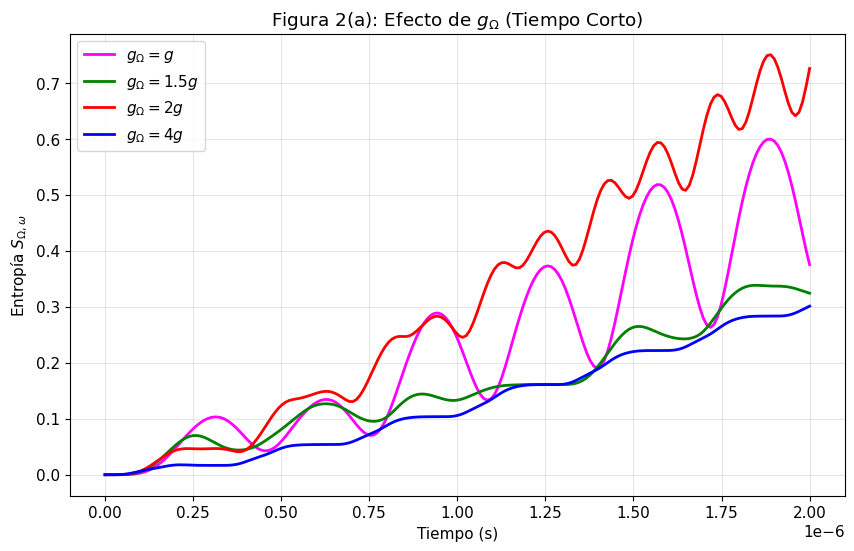

Generando Fig 2(b-e)...


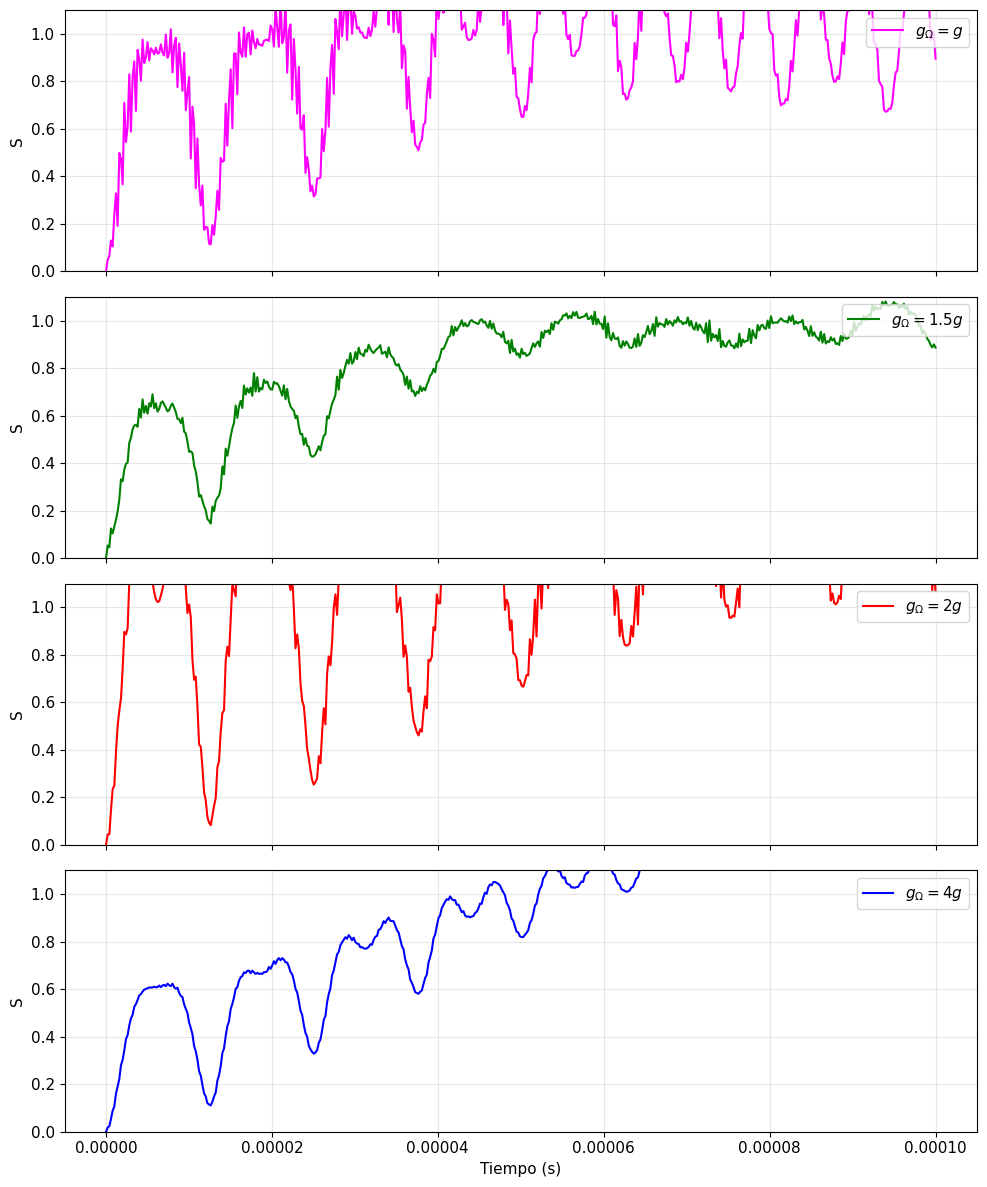

In [22]:
# FIGURA 2: EFECTO DE g_OMEGA
# Parámetros: g_phonon = 0.1g, zeta = g

g_ph = 0.1 * G_BASE
z = G_BASE

# Casos
cases = [
    (G_BASE, 'magenta', r'$g_\Omega = g$'),
    (1.5*G_BASE, 'green', r'$g_\Omega = 1.5g$'),
    (2.0*G_BASE, 'red', r'$g_\Omega = 2g$'),
    (4.0*G_BASE, 'blue', r'$g_\Omega = 4g$')
]

# Panel (a) - Tiempo corto (2e-6 s)
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

print("Generando Fig 2(a)...")
for g_om, col, lab in cases:
    t, S = run_simulation(g_om, g_ph, z, 2e-6, 200)
    ax.plot(t, S, color=col, label=lab, linewidth=2)

ax.set_title(r'Figura 2(a): Efecto de $g_\Omega$ (Tiempo Corto)')
ax.set_xlabel('Tiempo (s)')
ax.set_ylabel('Entropía $S_{\Omega, \omega}$')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# Panel (b-e) - Tiempo largo (1e-4 s)
print("Generando Fig 2(b-e)...")
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

for i, (g_om, col, lab) in enumerate(cases):
    t, S = run_simulation(g_om, g_ph, z, 1e-4, 500)
    axes[i].plot(t, S, color=col, label=lab)
    axes[i].set_ylabel('S')
    axes[i].legend(loc='upper right')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(0, 1.1)

axes[-1].set_xlabel('Tiempo (s)')
plt.tight_layout()
plt.show()

Generando Fig 3(a)...


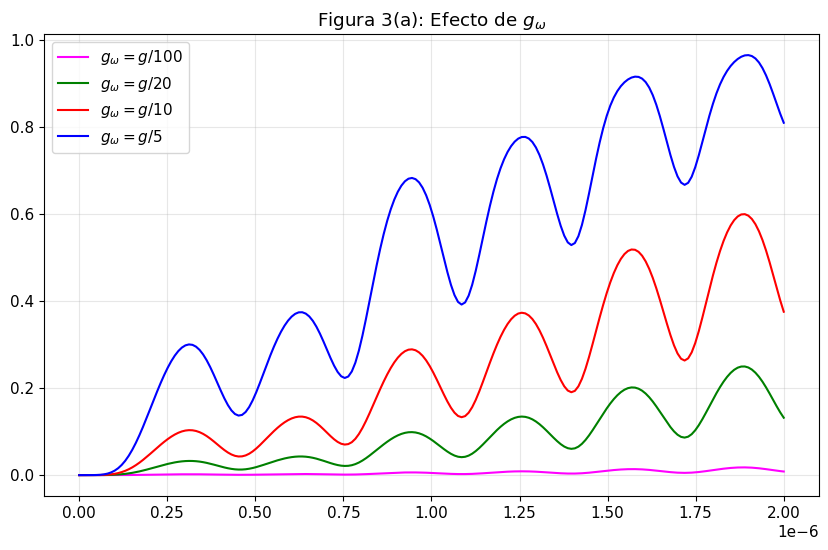

In [23]:
# FIGURA 3: EFECTO DE g_PHONON
# Parámetros: g_omega = g, zeta = g
g_om = G_BASE
z = G_BASE

cases_ph = [
    (G_BASE/100, 'magenta', r'$g_\omega = g/100$'),
    (G_BASE/20, 'green', r'$g_\omega = g/20$'),
    (G_BASE/10, 'red', r'$g_\omega = g/10$'),
    (G_BASE/5, 'blue', r'$g_\omega = g/5$')
]

plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
print("Generando Fig 3(a)...")

for g_p, col, lab in cases_ph:
    t, S = run_simulation(g_om, g_p, z, 2e-6, 200)
    ax.plot(t, S, color=col, label=lab)

ax.set_title(r'Figura 3(a): Efecto de $g_\omega$')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

Generando Fig 4(a)...


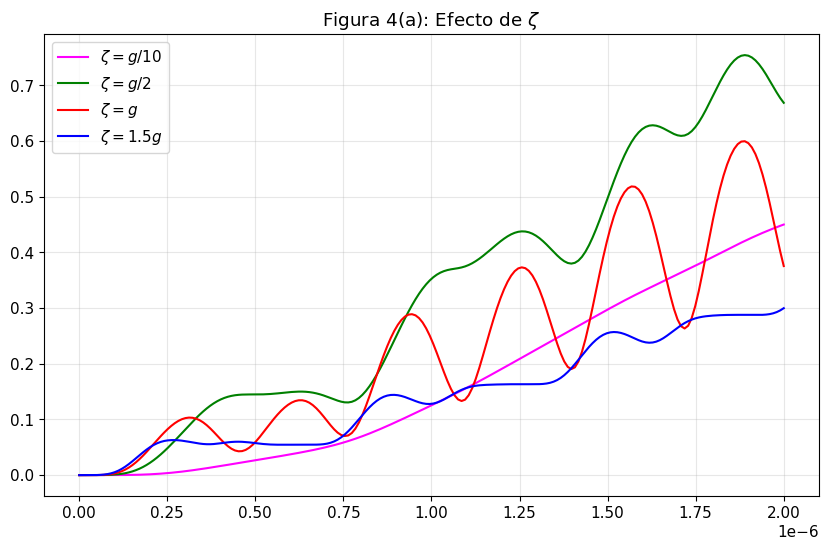

In [24]:
# FIGURA 4: EFECTO DE ZETA (Tunelamiento)
# Parámetros: g_omega = g, g_phonon = g/10
g_om = G_BASE
g_ph = G_BASE / 10

cases_z = [
    (G_BASE/10, 'magenta', r'$\zeta = g/10$'),
    (G_BASE/2, 'green', r'$\zeta = g/2$'),
    (G_BASE, 'red', r'$\zeta = g$'),
    (1.5*G_BASE, 'blue', r'$\zeta = 1.5g$')
]

plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
print("Generando Fig 4(a)...")

for val_z, col, lab in cases_z:
    t, S = run_simulation(g_om, g_ph, val_z, 2e-6, 200)
    ax.plot(t, S, color=col, label=lab)

ax.set_title(r'Figura 4(a): Efecto de $\zeta$')
ax.legend()
ax.grid(alpha=0.3)
plt.show()